# Welcome to the Leap Interpretability Engine!


If you don't have a Leap account, please [sign up for the waitlist here](https://www.leap-labs.com/) and we'll be in touch very soon (it's free)!

If you've already been invited, head over to [app.leap-labs.com](https://app.leap-labs.com) and generate your API key (don't forget to update the config dictionary and run the cell below).

![Yummy prototypes!](https://content.gitbook.com/content/PNm25tWoajlfjVGTw3eX/blobs/BfnJUa82bGGxKeTFlrht/C0B4EDF0-2401-4909-B598-83EAED4737AC.jpeg)

In [1]:
# Set up the config dictionary with your API key.
config = {"leap_api_key": "YOUR_LEAP_API_KEY"}

In [2]:
# Install the latest version of the library, and import the functions we need.
!pip install --upgrade --quiet leap-ie
from leap_ie.vision import engine
from leap_ie.vision.models import get_model

# widgets for drop-down selection.
import ipywidgets as widgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 80.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.8 MB/s eta 0:00:00


# What is the Interpretability Engine?

The interpretability engine is a python library and web dashboard that makes it easy to understand what computer vision models have learned from their training data. It does three key things:
1. [Generates prototypes](https://docs.leap-labs.com/concepts/prototypes)
2. [Calculates entanglement](https://docs.leap-labs.com/concepts/entanglements)
3. [Isolates features](https://docs.leap-labs.com/concepts/isolations)



# Getting Started with Prototype Generation

Using `get_model`, we can pull pre-trained models, along with their pre-processing and class labels, directly from torchvision or huggingface (experimental). You can interpret your own models too! For now, let's load a resnet18 model from torchvision.

For a full list of torchvision models, see [torchvision.models](https://pytorch.org/vision/0.8/models.html).

In [3]:
# Load a pretrained model from torchvision
preprocessing_fn, model, class_list = get_model("resnet18", source="torchvision")

class_name = widgets.Dropdown(
    options={v:k for k, v in dict(zip(range(len(class_list)), class_list)).items()}, value=55)

display(class_name)

Getting model torchvision.resnet18


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 87.9MB/s]


Dropdown(index=55, options={'tench': 0, 'goldfish': 1, 'great white shark': 2, 'tiger shark': 3, 'hammerhead':…

Next, let's choose some classes to generate prototypes for. You can select one from the dropdown above, or pass an array of indices.

In [41]:
# This is the index of the classes to generate. You can provide one, or many, e.g. [1,18], or [10,10,10]
target_classes = [class_name.value]
print('Target Classes: ', target_classes)

Target Classes:  [162]



And that's it - let's generate our first prototype! Run the cell below, and then head over to the [Leap dashboard](https://app.leap-labs.com/) to see the results as they come in.

Note that `project_name` groups the runs in the dashboard:



Pytorch mode enabled.
Found device: cuda
Generating class prototypes...
Using device cuda


100%|██████████| 1000/1000 [00:17<00:00, 57.57it/s]


Waiting for logging to complete...
Finishing...


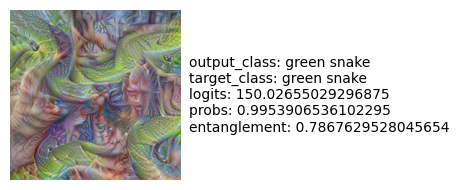

In [5]:
results_df, results_dict = engine.generate(project_name="resnet18", model=model, class_list=class_list, config=config,
                             target_classes=target_classes, preprocessing=preprocessing_fn)

engine.display_df(results_df)


Look at the prototype. Has the model learned correct features? Is there anything in there that shouldn't be, and might cause mistakes on unseen data?

#Entanglement
In the [Leap dashboard](https://app.leap-labs.com/) you'll notice a chart that looks like this:
[![alt text](https://content.gitbook.com/content/PNm25tWoajlfjVGTw3eX/blobs/EcgkS7Y3HGCKjqBFDiwf/B5E14A55-D70D-471F-A07A-D24A450A3FCF.jpeg)](https://docs.leap-labs.com/concepts/entanglements)

This chart shows you how a prototype's features are shared between other classes. Find out more about entanglement and what it means [here](https://docs.leap-labs.com/concepts/entanglements).

# Tensorflow

We (experimentally) support tensorflow models, too. Let's grab a keras model and see what it has learned about goldfish.

Make sure to pass `mode="tf"` to `engine.generate`

This model in particular benefits from a higher than normal learning rate during the generation process, as it was trained on un-scaled images, so let's adjust that in the config dictionary too (note that you shouldn't have to do this often, but try it and see).



Tensorflow mode enabled.
Found device: GPU
Generating class prototypes...
Using device GPU


100%|██████████| 1000/1000 [02:15<00:00,  7.36it/s]


Waiting for logging to complete...
Finishing...


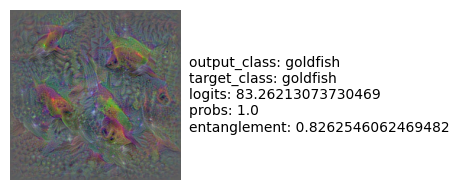

In [7]:
import tensorflow as tf
# We have the imagenet class list here, for your convenience :)
from leap_ie.vision import class_lists

# Class 1 = "goldfish"
target_classes = [1]

# We expect that the outputs of the model are logits, not probabilities - it's important that the classifier activation is None.
model = tf.keras.applications.mobilenet.MobileNet(weights="imagenet", include_top=True, classifier_activation=None)

preprocessing_fn = tf.keras.applications.mobilenet.preprocess_input

# Increasing learning rate.
config['lr'] = 2.0

# Note we have set mode="tf" for tensorflow.
results_df, results_dict = engine.generate(project_name="tf_mobilenet", model=model, class_list=class_lists.imagenet, target_classes=target_classes, config=config, preprocessing=preprocessing_fn, mode="tf")

engine.display_df(results_df)

# Reset learning rate to default.
config['lr'] = 0.01

# Config Options

Above we changed the learning rate in the config, and there are many more configurations to explore - [check out the docs for all of the options](https://docs.leap-labs.com/api-reference/engine.generate).

For example, the default number of generation steps is 1000. Some models need this many, but we can often extract prototypes more quickly - feel free to experiment! Let's see what happens if we change it to 500.

Getting model torchvision.resnet18
Pytorch mode enabled.
Found device: cuda
Generating class prototypes...
Using device cuda


100%|██████████| 500/500 [00:08<00:00, 59.60it/s]


Waiting for logging to complete...
Finishing...


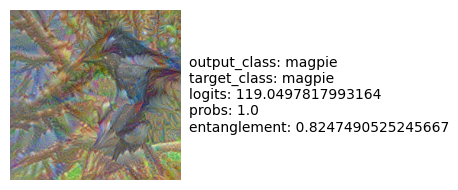

In [8]:
config["max_steps"] = 500

preprocessing_fn, model, class_list = get_model("resnet18", source="torchvision")

# Class 18 = "magpie"
target_classes = [18]

results_df, results_dict = engine.generate(project_name="resnet18", model=model, class_list=class_list, config=config,
                             target_classes=target_classes, preprocessing=preprocessing_fn)

engine.display_df(results_df)

# reset config
config["max_steps"] = 1000

By default, we blur the image during generation to remove adversarial noise. This sometimes results in indistinct prototypes. You can turn this off, and use a high-freqency penalty instead. Adjust the weight of the penalty with `hf_weight`.

Getting model torchvision.resnet18
Pytorch mode enabled.
Found device: cuda
Generating class prototypes...
Using device cuda


100%|██████████| 1000/1000 [00:16<00:00, 59.36it/s]


Waiting for logging to complete...
Finishing...


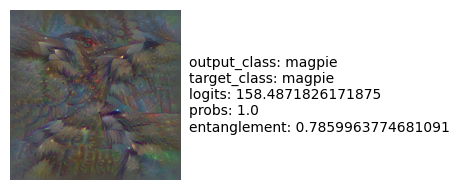

In [16]:
config["use_blur"] = False
config['hf_weight'] = 5
preprocessing_fn, model, class_list = get_model("resnet18", source="torchvision")

# Class 18 = "magpie"
target_classes = [18]

results_df, results_dict = engine.generate(project_name="resnet18", model=model, class_list=class_list, config=config,
                             target_classes=target_classes, preprocessing=preprocessing_fn)

engine.display_df(results_df)

#Reset config
config["use_blur"] = True
config['hf_weight'] = 0

This often results in darker images. You can adjust the postprocessing to compensate for this, using `equalise` in the config dictionary.

Getting model torchvision.resnet18
Pytorch mode enabled.
Found device: cuda
Generating class prototypes...
Using device cuda


100%|██████████| 1000/1000 [00:18<00:00, 55.40it/s]


Waiting for logging to complete...
Finishing...


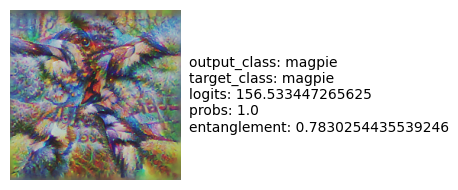

In [17]:
config["use_blur"] = False
config['hf_weight'] = 5
config["equalise"] = 0.5

preprocessing_fn, model, class_list = get_model("resnet18", source="torchvision")

# Class 18 = "magpie"
target_classes = [18]

results_df, results_dict = engine.generate(project_name="resnet18", model=model, class_list=class_list, config=config,
                             target_classes=target_classes, preprocessing=preprocessing_fn)

engine.display_df(results_df)

# reset config
config["use_blur"] = True
config['hf_weight'] = 0
config["equalise"] = 0

# Advanced prototype generation
We can also generate multiple class prototypes at once:

Getting model torchvision.resnet18
Selected classes: ['tiger', 'castle', 'lemon']
Pytorch mode enabled.
Found device: cuda
Generating class prototypes...
Using device cuda


100%|██████████| 1000/1000 [00:48<00:00, 20.46it/s]


Waiting for logging to complete...
Finishing...


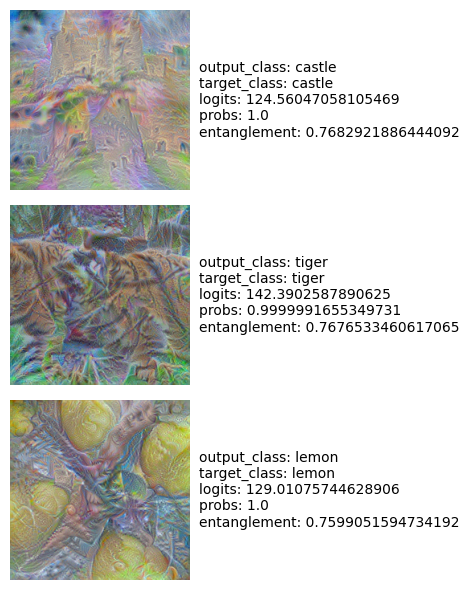

In [18]:
preprocessing_fn, model, class_list = get_model("resnet18", source="torchvision")

target_classes = [292, 483, 951]

print('Selected classes:', [class_list[t] for t in target_classes])

results_df, results_dict = engine.generate(project_name="resnet18", model=model, class_list=class_list, config=config,
                             target_classes=target_classes, preprocessing=preprocessing_fn)

engine.display_df(results_df)

You can also weight classes negatively, to generate antitypes! Here is the opposite of a lemon, according to resnet18.


Getting model torchvision.resnet18
Pytorch mode enabled.
Found device: cuda
Generating class prototypes...
Using device cuda


100%|██████████| 1000/1000 [00:16<00:00, 61.02it/s]


Waiting for logging to complete...
Finishing...


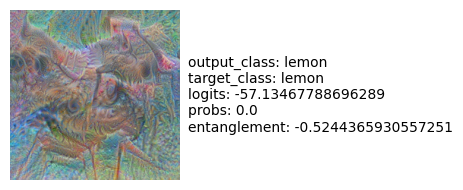

In [19]:
preprocessing_fn, model, class_list = get_model("resnet18", source="torchvision")

#class 951 is 'lemon'
target_classes = [951]
config["objective_weight"] = -1

results_df, results_dict = engine.generate(project_name="resnet18", model=model, class_list=class_list, config=config,
                             target_classes=target_classes, preprocessing=preprocessing_fn)

engine.display_df(results_df)

# reset config
config["objective_weight"] = 1

You can even generate hybrid prototypes, which combine the features of more than one class:

Getting model torchvision.resnet18
Pytorch mode enabled.
Found device: cuda
Generating class prototypes...
Using device cuda


100%|██████████| 1000/1000 [00:16<00:00, 59.34it/s]


Waiting for logging to complete...
Finishing...


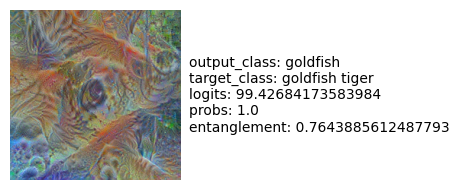

In [21]:
preprocessing_fn, model, class_list = get_model("resnet18", source="torchvision")

# goldfish/tiger hybrid
target_classes = [[1, 292]]

results_df, results_dict = engine.generate(project_name="resnet18", model=model, class_list=class_list, config=config,
                             target_classes=target_classes, preprocessing=preprocessing_fn)

engine.display_df(results_df)

# HuggingFace

We pull models from huggingface by passing the latter part of the URL to `get_model`, and will find (or approximate) their preprocessing and class labels too, if available. Let's generate prototypes from this food classifier: huggingface.co/**skylord/swin-finetuned-food101**.



Getting model skylord/swin-finetuned-food101
Checking huggingface for skylord/swin-finetuned-food101


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


Pytorch mode enabled.
Found device: cuda
Generating class prototypes...
Using device cuda


100%|██████████| 1000/1000 [03:29<00:00,  4.77it/s]


Waiting for logging to complete...
Finishing...


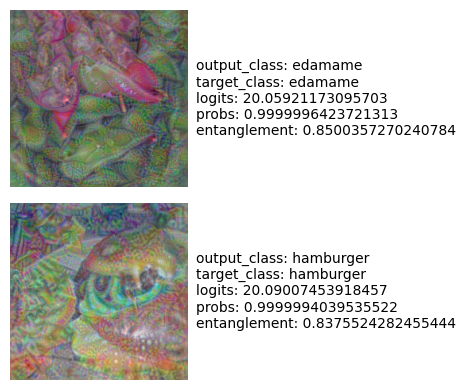

In [22]:
preprocessing_fn, model, class_list = get_model("skylord/swin-finetuned-food101", source="huggingface")

# burger, edamame
target_classes = [53,33]

results_df, results_dict = engine.generate(project_name="food", model=model, class_list=class_list, config=config,
                             target_classes=target_classes, preprocessing=preprocessing_fn)

engine.display_df(results_df)

# Segmentation Models

The engine supports segmentation models, too! Let's pull one from torchvision.

Getting model torchvision.segmentation.fcn_resnet50
Pytorch mode enabled.
Found device: cuda
Generating class prototypes...
Using device cuda


100%|██████████| 1000/1000 [01:10<00:00, 14.12it/s]


Waiting for logging to complete...
Finishing...


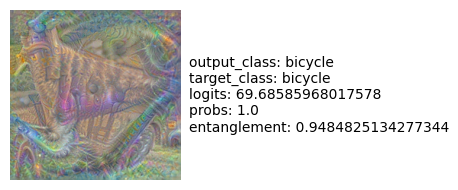

In [30]:
preprocessing_fn, model, class_list = get_model('fcn_resnet50', source='torchvision', segmentation=True)

target_classes = [2]

results_df, results_dict = engine.generate(project_name="fcn_resnet50", model=model, class_list=class_list, config=config,
                                target_classes=target_classes, preprocessing=preprocessing_fn)

engine.display_df(results_df)

# Custom models

We can extract prototypes for any differentiable image classifier. Here are some tips to get the engine working with your own models.

1. The default image size we expect is `[1,3,224,224]` for pytorch models, and `[1,224,224,3]` for tensorflow models. If your model expects a different image size, make sure to specify it in the config like this: `config["input_dim"] = [1,3,500,500]`. The first dimension is the batch size, and should always be `1`.

2. `engine.generate` takes a `preprocessing` argument. This should be a differentiable function that applies the same preprocessing you would apply to inputs during inference. If your preprocessing is not differentiable (i.e. we cannot propagate gradients through it), at the moment we don't support it - in this case, set `preprocessing` to `None`.

3. The engine expects your model to be fully differentiable, which can sometimes cause problems if, for example, your model returns an object or a dictionary. You may need to write a wrapper class, as shown below.

4. We also expect the output of your model to be raw logits, not probabilities. If your model outputs probabilities by default, simply replace the activation function of the final layer with `torch.nn.Identity()` or `tf.identity`.

config.json:   0%|          | 0.00/977 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/111M [00:00<?, ?B/s]

Pytorch mode enabled.
Found device: cuda
Generating class prototypes...
Using device cuda


100%|██████████| 1000/1000 [01:18<00:00, 12.78it/s]


Waiting for logging to complete...
Finishing...


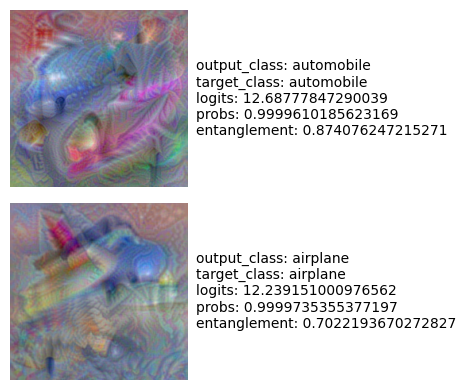

In [24]:
from torch import nn
from transformers import AutoImageProcessor, AutoModelForImageClassification

raw_model = AutoModelForImageClassification.from_pretrained("ahsanjavid/convnext-tiny-finetuned-cifar10")

class_list = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

class model_wrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model.eval()

    def forward(self, x):
        return self.model(x)["logits"]

model = model_wrapper(raw_model)

target_classes = [0,1]

results_df, results_dict = engine.generate(project_name="convnext_custom", model=model, class_list=class_list, config=config,
                                target_classes=target_classes, preprocessing=None)

engine.display_df(results_df)

Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]



Tensorflow mode enabled.
Found device: GPU
Generating class prototypes...
Using device GPU


100%|██████████| 1000/1000 [00:58<00:00, 17.20it/s]


Waiting for logging to complete...
Finishing...


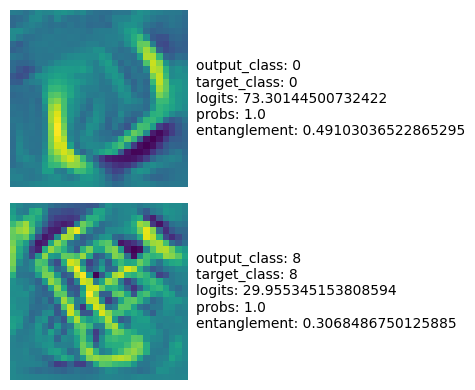

In [28]:
from huggingface_hub import from_pretrained_keras

model = from_pretrained_keras("keras-io/simple-mnist-convnet")

# Remove softmax from final layer
model.layers[-1].activation = tf.identity

# Non-standard input dimensions
config["input_dim"] = [1,28,28,1]

# You may need to specify the channel index for custom input dimensions, if it's not clear from the provided input_dim
config["channel_ix"] = 3

class_list = [str(s) for s in range(10)]
target_classes = [0,8]

results_df, results_dict = engine.generate(project_name="mnist_convnet", model=model, class_list=class_list, config=config,
                                target_classes=target_classes, preprocessing=None, mode='tf')

engine.display_df(results_df)

#reset config
config["input_dim"] = [1,3,224,224]
config["channel_ix"] = 1

# Feature Isolation on Prototypes

The interpretability engine can also perform [feature isolation](https://docs.leap-labs.com/concepts/isolations), to identify *which* features in a prototype are shared with other classes. Enable this by setting `"isolation" = True` in the config dictionary. Let's see it in action!

**Note, full results are not displayed here. Head to the [dashboard](https://app.leap-labs.com/) to see everything!**

Getting model torchvision.resnet18
Pytorch mode enabled.
Found device: cuda
Generating class prototypes...
Using device cuda


100%|██████████| 1000/1000 [00:16<00:00, 61.51it/s]


Isolating salient features...
Isolating features for: ['goldfish', 'barracouta', 'axolotl']
Using device cuda


100%|██████████| 1000/1000 [00:50<00:00, 19.97it/s]


Waiting for logging to complete...
Finishing...


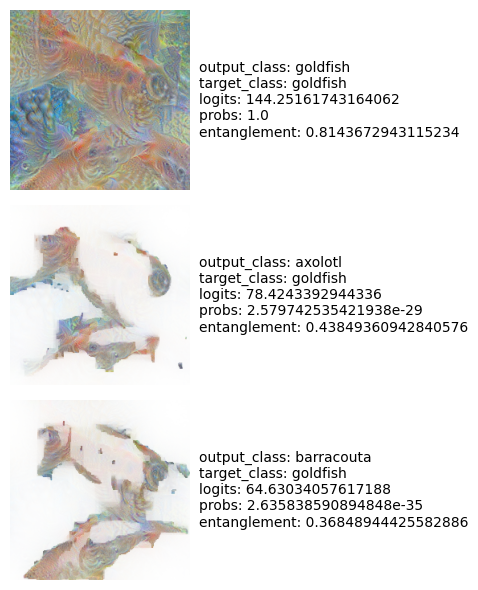

In [31]:
config["isolation"] = True

preprocessing_fn, model, class_list = get_model("resnet18", source="torchvision")

# Class 1 = "goldfish"
target_classes = [1]

results_df, results_dict = engine.generate(project_name="resnet18_isolation", model=model, class_list=class_list, config=config,
                             target_classes=target_classes, preprocessing=preprocessing_fn)

engine.display_df(results_df)

# reset config
config["isolation"] = False

# Feature Isolation on Real Images

We can also do [feature isolation](https://docs.leap-labs.com/concepts/isolations) on real images, to identify which features contribute to the model's prediction!

To do this, pass a tensor of images to `engine.generate`.

In [32]:
from PIL import Image
import requests
from io import BytesIO
from torchvision import transforms
import torch

def load_image(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert('RGB')

    preprocess = transforms.Compose([
        transforms.Resize(224, interpolation=Image.BICUBIC),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ])
    input_tensor = preprocess(img)
    input_batch = input_tensor.unsqueeze(0)

    return input_batch

  # Load an image from url

url = "https://www.safetyliftingear.com/news/image.axd?picture=/tools.png"
input_tensor = load_image(url)

Getting model torchvision.resnet18
Pytorch mode enabled.
Found device: cuda
Isolating salient features...
Samples found...
Isolating features for: ["carpenter's kit", 'hammer', 'screwdriver']
Using device cuda


100%|██████████| 1000/1000 [00:50<00:00, 19.89it/s]


Waiting for logging to complete...
Finishing...


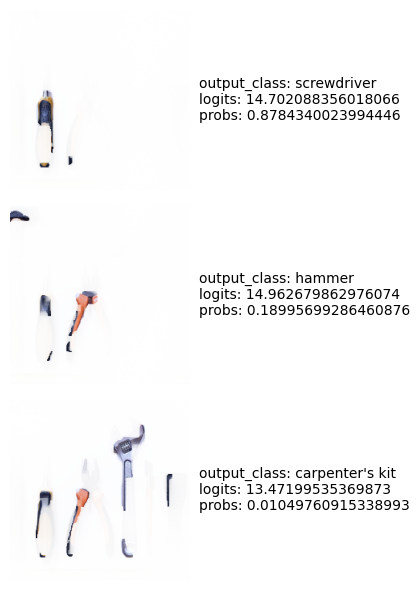

In [33]:
config["isolation"] = True

preprocessing_fn, model, class_list = get_model("resnet18", source="torchvision")

results_df, results_dict = engine.generate(project_name="resnet18_isolation", model=model, class_list=class_list, config=config, preprocessing=preprocessing_fn, samples=input_tensor)

engine.display_df(results_df)

# reset config
config["isolation"] = False

# Feature Isolation Config

By default we isolate features for the top three classes with highest probability. To change this number, adjust `"max_isolate_classes"` in the config.

Just like with prototype generation, you can adjust the learning rate and high frequency penalty weight for isolations in the config using `"isolation_lr"` and `"isolation_hf_weight"`.

There's an additional option, `"isolation_alpha_weight"` which determines how much of the input image is obscured. Try experimenting with these! Here's an example:

Getting model torchvision.resnet18
Pytorch mode enabled.
Found device: cuda
Isolating salient features...
Samples found...
Isolating features for: ["carpenter's kit", 'hammer']
Using device cuda


100%|██████████| 1000/1000 [00:34<00:00, 29.38it/s]


Waiting for logging to complete...
Finishing...


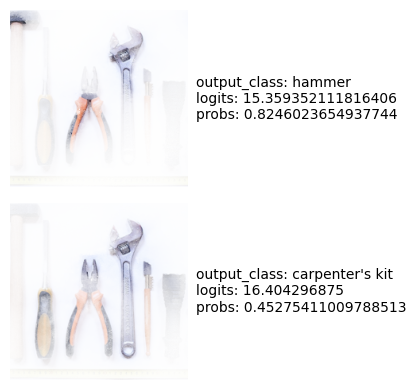

In [35]:
config["isolation"] = True
config["isolation_alpha_weight"] = 0.1
config["max_isolate_classes"] = 2

preprocessing_fn, model, class_list = get_model("resnet18", source="torchvision")

results_df, results_dict = engine.generate(project_name="resnet18_isolation", model=model, class_list=class_list, config=config, preprocessing=preprocessing_fn, samples=input_tensor)

engine.display_df(results_df)

# reset config
config["isolation_alpha_weight"] = 1.0
config["max_isolate_classes"] = 3
config["isolation"] = False


You can also specify *which* classes to isolate features for by passing an array of `target_classes` to `engine.generate`, as we did with prototype generation.

Getting model torchvision.resnet18
Pytorch mode enabled.
Found device: cuda
Isolating salient features...
Samples found...
Isolating features for: ['screwdriver']
Using device cuda


100%|██████████| 1000/1000 [00:17<00:00, 58.60it/s]


Waiting for logging to complete...
Finishing...


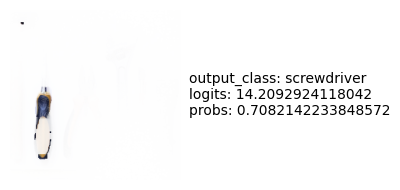

In [36]:
config["isolation"] = True

preprocessing_fn, model, class_list = get_model("resnet18", source="torchvision")

# screwdriver
target_classes = [784]

results_df, results_dict = engine.generate(project_name="resnet18_isolation", model=model, class_list=class_list, config=config, preprocessing=preprocessing_fn, samples=input_tensor, target_classes=target_classes)

engine.display_df(results_df)

# reset config
config["isolation"] = False

# Weights and Biases

We can also log results directly to your weights and biases dashboard - simply update the config with your WandB credentials like so. We will log to the WandB project with the same `project_name`, or create a new one if it doesn't exist.

Getting model torchvision.resnet18
Pytorch mode enabled.
Found device: cuda
Generating class prototypes...
Using device cuda


100%|██████████| 1000/1000 [00:17<00:00, 56.17it/s]


Waiting for logging to complete...
Finishing...


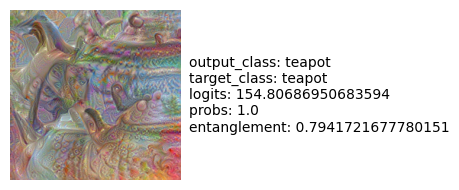

In [40]:
config = {"leap_api_key": "YOUR_LEAP_API_KEY",
          "wandb_entity": "YOUR_WANDB_ENTITY",
          "wandb_api_key": "YOUR_WANDB_API_KEY"}

target_classes = [849]
preprocessing_fn, model, class_list = get_model("resnet18", source="torchvision")

results_df, results_dict = engine.generate(project_name="resnet18", model=model, class_list=class_list, config=config,
                             target_classes=target_classes, preprocessing=preprocessing_fn)

engine.display_df(results_df)